In [29]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy import stats
import warnings
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import swifter
sys.path.append('../')
pd.options.mode.chained_assignment = None 



In [2]:
#DISTANCE THRESHOLD
#used to classify an event as entering or exiting
#when two consecutive detections of the same event 
#have this distance in y position, they are utilized to predict
#the trajectory. If not then it checks the detection prior for
#the distance threshold, and continues doing so until it finds
#the last detection in the event or until it finds a distance
#of more than the threshold

t2 = 150

#ANGLE THRESHOLD
#used to generate angle ranges for classifying as exiting
#or entering

angle = 10

In [3]:
#combine all CSV's of the same data
files = open("bees/files.txt")
filenames = []
while True:
    line = files.readline().strip()
    if not line:
        break
    filenames.append("bees/" + line)

vdf = pd.concat(map(pd.read_csv, filenames), ignore_index=True)

In [4]:
vdf['track_tagid'] = vdf['track_tagid'].astype(str)
vdf['track_starttime'] = pd.to_datetime(vdf['track_starttime'])
vdf['track_endtime'] = pd.to_datetime(vdf['track_endtime'])
#fill missing tagids
vdf['track_tagid'] = (
    vdf.groupby(['video_name', 'track_tagid'])['track_tagid']
       .transform(lambda s: s.ffill().bfill())
)
vdf.fillna(method='ffill', inplace=True)
vdf = vdf.sort_values(by=['track_tagid','track_tagid'])




In [5]:
#make tracks single rows
tracks = (vdf.groupby(['video_name','track_id'], as_index=False)
            .agg(track_tagid=('track_tagid','first'),
                 start=('track_starttime','first'),
                 end=('track_endtime','first')))

#sort by video name, track id and start
tracks = tracks.sort_values(['video_name','track_tagid','start'])

#obtain breakpoints of 5 second gaps
tracks['gap_s'] = (
    tracks['start'] - tracks.groupby(['video_name','track_tagid'])['end'].shift()
).dt.total_seconds()

#mark as breakpoints
tracks['split'] = tracks['gap_s'].isna() | (tracks['gap_s'] > 5)

#segment to obtain track values by individual ids
tracks['segment'] = tracks.groupby(['video_name','track_tagid'])['split'].cumsum()

#group by unique ids and tracks
tracks['group_id'] = tracks.groupby(['video_name','track_tagid','segment']).ngroup()


In [6]:
vdf = vdf.merge(
    tracks[['video_name','track_id','group_id']],
    on=['video_name','track_id'],
    how='left',
    suffixes=('','_new')
)

In [7]:
len(vdf['group_id'].unique())

20978

## RULES

In [8]:
####CLASSIFICATION AS ENTERING-EXITING OR EXITING-ENTERING

def getangle(coordinates):
    exit_min = 180 + angle
    exit_max = 360 - angle
    enter_min = angle
    enter_max = 180 - angle

    avg_x = np.cos(np.deg2rad(coordinates))
    avg_y = np.sin(np.deg2rad(coordinates))
    if avg_x == 0 and avg_y == 0:
        deg = 0
    elif avg_x == 0 and avg_y != 0:
        if avg_y > 0:
            deg = 270
        elif avg_y < 0:
            deg = 90
    else:
        # determine direction angle using arctan
        deg = np.rad2deg(np.arctan(avg_y/avg_x))
                    
        # since arctan limits are (-90,90), use coordinate directions to 
        # correct the angle to be within standard [0,360) range
        if avg_x > 0 and avg_y >= 0:
            deg = deg
        elif avg_x < 0 and avg_y >= 0:
            deg = 180 + deg
        elif avg_x < 0 and avg_y < 0:
            deg = deg + 180
        elif avg_x > 0 and avg_y < 0:
            deg = 360 + deg

    if deg >= exit_min and deg <= exit_max:
        return 'exiting'
    elif deg >= enter_min and deg <= enter_max:
        return 'entering'
    else:
        return 'unknown'

#RULE 1 ITERATE BACKWARDS AND FORWARDS DISPLACEMENT
def displacementbackforth(data):   

        coordinates = data['cy']

        #ending movement
        if len(coordinates) > 0:
            final = coordinates.iloc[-1]
            
            for k in range(len(coordinates)):
                prev = coordinates.iloc[len(coordinates)-k-1]
                dif = final - prev
                if abs(dif) >= t2:
                    if dif < 0:
                        string2 = 'exiting'
                    elif dif > 0:
                        string2 = 'entering'
                    else:
                        string2 = 'unknown'
                    break
                elif k == len(coordinates) - 1:
                    if dif < 0:
                        string2 = 'exiting'
                    elif dif > 0:
                        string2 = 'entering'
                    else:
                        string2 = 'unknown'
    
            #beginning movement
            #iterate forwards
            first = coordinates.iloc[0]
            
            for k in range(0,len(coordinates)):
                next = coordinates.iloc[k]
                dif = first - next
                if abs(dif) >= t2:
                    if dif > 0:
                        string = 'exiting'
                    elif dif < 0:
                        string = 'entering'
                    else:
                        string = 'unknown'
                    break
                elif k == len(coordinates) - 1:
                    if dif > 0:
                        string = 'exiting'
                    elif dif < 0:
                        string = 'entering'
                    else:
                        string = 'unknown'
    
            return string if string == string2 else f"{string}-{string2}"
        else:
            return 'unknown'
        

#RULE 2 FIRST AND LAST DIRECTIONAL ANGLE
    

def lastfirstangle(data):

    if len(data) > 0:
        coordinates = data['angle'].iloc[-1]
    
        string2 = getangle(coordinates)
    
        coordinates = data['angle'].iloc[0]
    
        string = getangle(coordinates)
    
        return string if string == string2 else f"{string}-{string2}"
    else:
        return 'unknown'

#RULE 3 THRESHOLD BIDIRECTIONAL
def in_out2(data):
    first = data['track_shape'].iloc[0].split("_")[0]
    last =  data['track_shape'].iloc[-1].split("_")[1]
    shape = f'{first}_{last}'
    if shape == "inside_outside" or shape == "ramp_outside":
        return "exiting"
    elif shape == "outside_inside" or shape == "outside_ramp":
        return "entering"
    elif shape == "outside_outside":
        return "entering-exiting"
    elif shape == "inside_inside":
        return "exiting-entering"
    else:
        return "unknown"
        


In [21]:
#classify all events
events = vdf['group_id'].unique()
for_matrix2 = {}

functions = {
    'THRS_BIDIRECTIONAL':in_out2,
    'DISP_BIDIRECTIONAL': displacementbackforth,
    'BEE_ANGLE_BIDIRECTIONAL': lastfirstangle  
}

for APPROACHES, func in functions.items():
    for_matrix2[APPROACHES] = []

for i in events:
    detections = vdf[vdf['group_id'] == i]
    unknowns = ['unknown-entering','unknown-exiting','exiting-unknown','entering-unknown']
    for APPROACHES, func in functions.items():
        result = func(detections)
        if result in unknowns:
            result = 'unknown'
        for_matrix2[APPROACHES].append(result)



In [33]:
#generates graphs of distribution of classes
#label is used for the name of the file i.e. 'simple', 'compound'
def generate_dist(the_matrix,label,hatches):
    the_df = []
    for c in the_matrix.columns:
        column = the_matrix[c]
        values = column.value_counts()
        df = values.rename("count").reset_index()
        df["algo"] = c
        df = df.rename(columns={df.columns[0]:'event'})
        the_df.append(df)
    full_df = pd.concat(the_df, ignore_index=True)

    stacked = full_df.pivot_table(
    index="algo", 
    columns="event", 
    values="count",
    fill_value=0
    )
    stacked = stacked.reindex(the_matrix.columns)

    event_hatches = {
        event: hatches[i % len(hatches)]
        for i, event in enumerate(stacked.columns)
    }

    fig, ax = plt.subplots(figsize=(10, 6))
    bottom = np.zeros(len(stacked))

    for event in stacked.columns:
        values = stacked[event].values

        colors = [palette[a] for a in stacked.index]

        bars = ax.bar(
            stacked.index,
            values,
            bottom=bottom,
            color=colors,
            edgecolor="white",
            label=event
        )

        # hatch by event (same hatch for this whole layer)
        hatch = event_hatches[event]
        for bar in bars:
            bar.set_hatch(hatch)

        bottom += values

    hatch_handles = [
        mpatches.Patch(
            facecolor='gray',
            edgecolor='white',
            hatch=event_hatches[event],
            label=event
        )
        for event in stacked.columns
    ]

    ax.legend(
    handles=hatch_handles,
    title="Event",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5)
    )

    ax.tick_params(axis='x', labelrotation=90)
    ax.grid(True, axis="y", color="gray", alpha=0.5) 
    ax.set_ylabel("Count")
    ax.set_axisbelow(True)
    ax.set_xlabel("Algorithm")
    plt.tight_layout()
    plt.show()

    fig.savefig(f"{label}-count.png",bbox_inches='tight',bbox_extra_artists=(ax.get_legend(),)) 

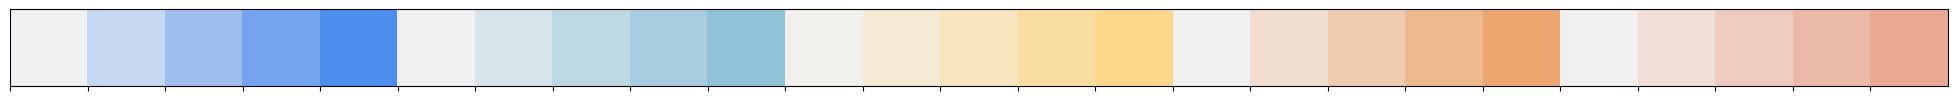

In [26]:
colors =['#4C8CED','#90C2D8','#FCD88D','#ECA771','#EBA991']
full_palette = sns.color_palette(colors)
sns.set_palette(full_palette)
third_class = 'unknown'
expanded_palette = []

for color in colors:
    shades = sns.light_palette(color, n_colors=5)
    expanded_palette.extend(shades)

expanded_palette
sns.palplot(expanded_palette)

In [27]:
palette = {
    "THRS_BIDIRECTIONAL":    expanded_palette[4],
    "BEE_ANGLE_BIDIRECTIONAL": expanded_palette[9],
    "DISP_BIDIRECTIONAL":expanded_palette[24],
}

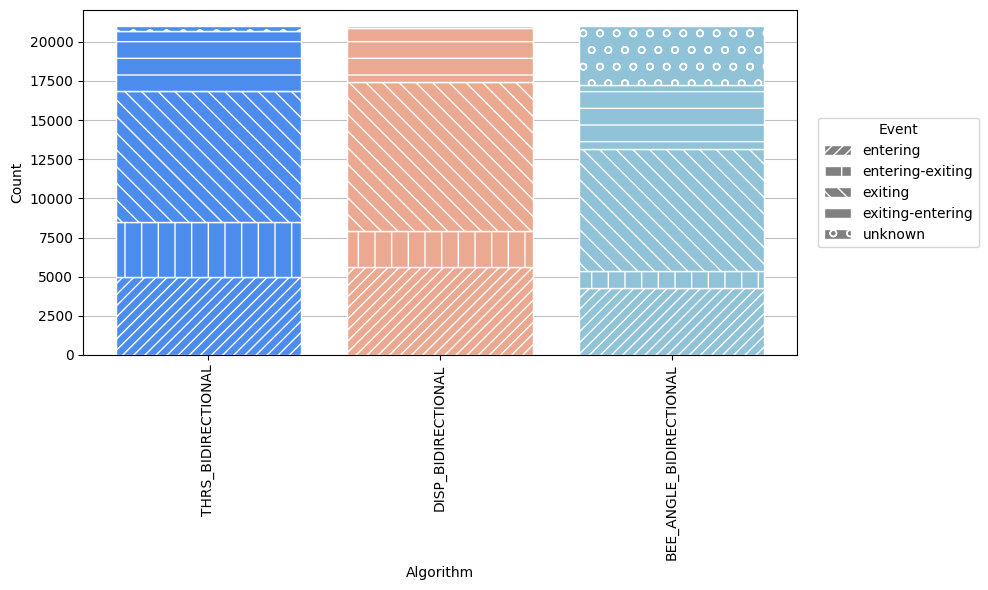

In [34]:
compound_matrix = pd.DataFrame.from_dict(for_matrix2)
generate_dist(compound_matrix,"full",["///","|","\\\\","-","o"])

In [40]:
compound = ['exiting-entering','entering-exiting']
for k in compound_matrix.columns:
    col = compound_matrix[k]
    print(k)
    print(col.isin(compound).sum())

THRS_BIDIRECTIONAL
7367
DISP_BIDIRECTIONAL
5719
BEE_ANGLE_BIDIRECTIONAL
5208


In [16]:
len(events)

20978